In [1]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [2]:
def preprocess(df):
    df["timestamp"] = pd.to_datetime(df['timestamp'], unit='s')
    df["year"] = df["timestamp"].dt.year
    df["month"] = df["timestamp"].dt.month
    df["day"] = df["timestamp"].dt.day
    df["hour"] = df["timestamp"].dt.hour
    df = df.drop(['timestamp', 'source'], axis=1)

    df = df[df['is_fishing'] != -1]
    df['is_fishing'] = df['is_fishing'] > 0.5
    df["course"] = df["course"].apply(lambda x: x - 360 if x >= 360 else x)
    return df

In [3]:
def generate_mmsi_samples(df, target, test_size=0.2, random_seed=42):
    np.random.seed(random_seed)
    mmsi_list = df['mmsi'].unique()
    test_num = int(len(mmsi_list) * test_size)
    mmsi_test = np.random.choice(mmsi_list, size=test_num, replace=False)
    df_test = df[df['mmsi'].isin(mmsi_test)].drop('mmsi', axis=1)
    df_train = df[~df['mmsi'].isin(mmsi_test)].drop('mmsi', axis=1)
    return df_train.drop(target, axis=1), df_test.drop(target, axis=1), df_train[target], df_test[target]

In [4]:
def lgb_train(train, target):
    data = lgb.Dataset(x_train, y_train)
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'max_depth': 5,
        'num_leaves': 200,
        'bagging_fraction': 0.9,
        'colsample_bytree': 0.9,
        'learning_rate': 0.03,
        'verbose': -1
    }
    model = lgb.train(params, data, num_boost_round=300)
    return model

In [5]:
def xgb_train(train, target):
    params = {
        'objective': 'binary:logistic',
        'colsample_bytree': 0.8,
        'colsample_bylevel': 0.8,
        'eval_metric': 'aucpr',
        'max_depth': 5,
        'eta': 0.05,
        'gamma': 0.1,
        'lambda': 2,
        'subsample': 0.8
    }
    data = xgb.DMatrix(train, target)
    model = xgb.train(params, data, num_boost_round=200)
    return model

In [6]:
df = pd.read_csv(os.path.join('data', 'trawlers.csv'))
df = preprocess(df)
x_train, x_test, y_train, y_test = generate_mmsi_samples(df, target='is_fishing', test_size=0.2, random_seed=42)
x_train.shape, x_test.shape

((116866, 10), (60528, 10))

## LightGBM

In [7]:
model = lgb_train(x_train, y_train)

In [8]:
y_pred = model.predict(x_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
print("auc:", metrics.auc(fpr, tpr))

y_pred = y_pred.round(0)
print("f1 score:", metrics.f1_score(y_test, y_pred))
print("precision :", metrics.precision_score(y_test, y_pred))
print("recall :", metrics.recall_score(y_test, y_pred))

auc: 0.9490949144751835
f1 score: 0.8772061882217776
precision : 0.853420697629601
recall : 0.9023555301980601


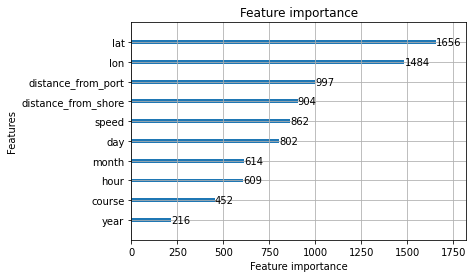

In [9]:
lgb.plot_importance(model)
plt.show()

## XGboost

In [10]:
model = xgb_train(x_train, y_train)

In [11]:
dtest = xgb.DMatrix(x_test, y_test)

y_pred = model.predict(dtest)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
print("auc:", metrics.auc(fpr, tpr))

y_pred = y_pred.round(0)
print("f1 score:", metrics.f1_score(y_test, y_pred))
print("precision :", metrics.precision_score(y_test, y_pred))
print("recall :", metrics.recall_score(y_test, y_pred))

auc: 0.9448080284706104
f1 score: 0.8787855044074437
precision : 0.8460697042848522
recall : 0.914133181188361


In [12]:
def xgb_plot_importance(model, save_as=None):
    feature_names = list(model.get_score().keys())
    feature_importance = list(model.get_score().values())
    d = pd.DataFrame(data={'feature': feature_names, 'importance': feature_importance})
    d = d.sort_values(by='importance', ascending=True)

    d.plot.barh('feature', 'importance')
    plt.title('Feature Importance')
    plt.xlabel('Weight')
    plt.ylabel('Features')
    plt.grid()
    if save_as:
        plt.savefig(save_as, bbox_inches='tight')
    plt.show()
    return

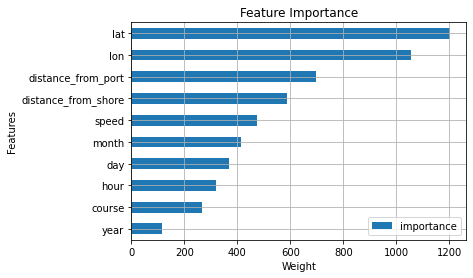

In [13]:
xgb_plot_importance(model)